In [1]:
!pip install gdown
#from cld_data_processing import download_data

In [13]:
import gdown
import keras
import pandas as pd
import shutil
import tensorflow as tf
import os
import zipfile

from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.data import Dataset

from typing import NamedTuple, Tuple

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
class Params(NamedTuple):
    """
    Job Parameters
    """
    image_size: int
    batch_size: int
    epochs: int
    early_stopping: bool
    early_stopping_patience: int
    adjust_learning_rate: bool

In [4]:
tf.random.set_seed(67890)

DEFAULT_PARAMS = Params(255, 196, 50, True, 5, False)
DEFAULT_PARAMS

Params(image_size=255, batch_size=196, epochs=50, early_stopping=True, early_stopping_patience=5, adjust_learning_rate=False)

`/data/data_processing.py`

In [5]:
def create_ds_tree(x, y, path, name) -> Path:
    """
    
    """
    ds_path = path / name
    if not ds_path.exists():
        ds_path.mkdir(parents=True, exist_ok=True)

        for lab in y.unique():
            (ds_path / str(lab)).mkdir(exist_ok=True)

        source_path = path / "train_images"
        
        for img, lab in zip(x, y):
            src = source_path / img
            dest = ds_path / str(lab) / img
            shutil.move(src, dest)
        
    return ds_path


def create_dataset(path: Path, params: Params) -> Dataset:
    """
    """
    img_size = params.image_size
    return image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='categorical',
        image_size=[img_size, img_size],
        batch_size=params.batch_size,
    )


def augment_dataset(ds: Dataset, num_repeats: int) -> Dataset:
    def augment(image, label):
        seed = 12345
        image = tf.image.random_flip_left_right(image, seed)
        image = tf.image.random_flip_up_down(image, seed)
        image = tf.image.random_brightness(image, 0.2, seed)
        return image, label

    AUTOTUNE = tf.data.experimental.AUTOTUNE
    return (
        ds
        .repeat(num_repeats)
        .map(augment)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )
    
    
def download_data(path: Path, force=False) -> Path:
    """
    """
    url = "https://drive.google.com/uc?id=1TJBf1HZxAMpowZ92BcgS5N_NPHE7LPOT"
    output = path / "data.zip"
    if not Path(output).exists() or force:
        gdown.download(url, str(output), quiet=False)
    return output


def data_preprocessing(path: Path, params: Params, force=False) -> Tuple[Dataset, Dataset, Dataset]:
    """
    """
    file = download_data(path, force)
    
    data_path = path / "data"
    if force:
        shutil.rmtree(data_path)
        
    if not data_path.exists():
        data_path.mkdir(parents=True, exist_ok=True)
       
        with zipfile.ZipFile(file, "r") as z:
            z.extractall(data_path)
        
    df_images = pd.read_csv((data_path / "train.csv"))
    
    X_train, X_test, y_train, y_test = train_test_split(df_images.image_id, df_images.label, test_size=0.2, random_state=12)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=12)
    
    train_path = create_ds_tree(X_train, y_train, data_path, "train")
    valid_path = create_ds_tree(X_valid, y_valid, data_path, "valid")
    test_path = create_ds_tree(X_test, y_test, data_path, "test")
    
    ds_train = create_dataset(train_path, params)
    ds_valid = create_dataset(valid_path, params)
    ds_test = create_dataset(test_path, params)

    return ds_train, ds_valid, ds_test

In [6]:
# def data_cleanup() -> None:
#     # clean-up
#     try:
#         os.rmdir((data_path / "train_images"))
#         os.remove(file)
#     except Exception:
#          pass

`/model/utils.py`

In [7]:
def model_convnext_tiny(params: Params) -> Model:
    
    base_model = tf.keras.applications.ConvNeXtTiny(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    img_size = params.image_size
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(img_size, img_size, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])

In [18]:
def run_experiment(exp_id: str, sub_exp_id: int, model_fn: str,
                      ds_train_: Dataset, ds_valid_: Dataset, params: Params) -> Tuple[Model, pd.DataFrame]:
    
    model = model_fn(params)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(epsilon=0.005),
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )

    early_stopping = callbacks.EarlyStopping(
        min_delta=0.0001,
        patience=params.early_stopping_patience,
        restore_best_weights=True,
        verbose = 1
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor = 'val_loss', factor = 0.3, 
        patience = 3, min_delta = 0.001, 
        mode = 'min', verbose = 1)
    
    cbs = []
    if params.early_stopping:
        print("Using EarlyStopping")
        cbs += [early_stopping]
    if params.adjust_learning_rate:
        print("Using ReduceLROnPlateau")
        cbs += [reduce_lr]

    history = model.fit(
        ds_train_,
        validation_data=ds_valid_,
        epochs=params.epochs,
        verbose=1,
        callbacks=cbs
    )
    
    df_hist = pd.DataFrame(history.history)
    df_hist = df_hist.reset_index()
    df_hist["exp_id"] = exp_id
    df_hist["sub_exp_id"] = sub_exp_id
    df_hist["epoch"] = df_hist.index
   
    return model, df_hist

In [9]:
def add_results(df_all_results, df_new_results):
    if df_all_results.empty:
        return df_new_results
    else:
        return pd.concat([df_all_results, df_new_results])


def recover_results() -> pd.DataFrame:
    file = "results.csv"
    if Path(file).exists():
        return pd.read_csv(file)
    return pd.DataFrame

In [11]:
def plot_experiment_results(df_history: pd.DataFrame, exp_id: str, epoch_limit = 50) -> None:
    df = df_history[(df_history.exp_id == exp_id) & (df_history.epoch <= epoch_limit)].copy()
    df["loss_gap"] = df.val_loss - df.loss
    df_loss = df[["epoch", "loss", "val_loss"]].groupby(["epoch"]).mean()
    df_loss_gap = df[["epoch", "loss_gap"]].groupby(["epoch"]).mean()
    df_acc = df[["epoch", "accuracy", "val_accuracy"]].groupby(["epoch"]).mean()
    df_loss.plot()
    df_loss_gap.plot()
    df_acc.plot();
    
def plot_experiments_comp(df_history: pd.DataFrame, exp_id: list, y_dim: str, epoch_limit = 50) -> None:
    df = df_history[(df_history.exp_id.isin(exp_id)) & (df_history.epoch <= epoch_limit)].copy()
    df["loss_gap"] = df.val_loss - df.loss
    df_grp = df[["epoch","exp_id", y_dim]].groupby(["epoch", "exp_id"]).mean()
    sns.lineplot(data=df_grp, x="epoch", y=y_dim, hue="exp_id")

`main.py`

In [14]:
cwd = os.getcwd()
ds_train, ds_valid, ds_test = data_preprocessing(Path(cwd), DEFAULT_PARAMS)

Downloading...
From (original): https://drive.google.com/uc?id=1TJBf1HZxAMpowZ92BcgS5N_NPHE7LPOT
From (redirected): https://drive.google.com/uc?id=1TJBf1HZxAMpowZ92BcgS5N_NPHE7LPOT&confirm=t&uuid=bcf23c5c-6eb1-49da-aca9-dc73305e3790
To: /kaggle/working/data.zip
100%|██████████| 656M/656M [00:33<00:00, 19.3MB/s] 


Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.


In [16]:
df_results = recover_results()

In [20]:
(m, df_hist) = run_experiment("model_convnext_tiny", 1, model_convnext_tiny, ds_train, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

m.evaluate(ds_test)

111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Using EarlyStopping
Epoch 1/50


I0000 00:00:1710863885.606335     155 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710863885.644034     155 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710863885.644406     155 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710863885.644873     155 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.5234 - loss: 1.3530

W0000 00:00:1710863929.068746     153 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710863929.069102     153 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710863929.069732     153 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.5245 - loss: 1.3500

W0000 00:00:1710863934.538468     154 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710863934.538798     154 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710863934.539206     154 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710863955.376767     155 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710863955.377079     155 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710863955.377550     155 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


66/66 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.5255 - loss: 1.3472 - val_accuracy: 0.6680 - val_loss: 0.8698
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 47s 702ms/step - accuracy: 0.6532 - loss: 0.9322 - val_accuracy: 0.6988 - val_loss: 0.7941
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 47s 702ms/step - accuracy: 0.6824 - loss: 0.8506 - val_accuracy: 0.7140 - val_loss: 0.7642
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 47s 704ms/step - accuracy: 0.6874 - loss: 0.8215 - val_accuracy: 0.7210 - val_loss: 0.7390
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 47s 704ms/step - accuracy: 0.7063 - loss: 0.7787 - val_accuracy: 0.7241 - val_loss: 0.7283
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 47s 703ms/step - accuracy: 0.7072 - loss: 0.7699 - val_accuracy: 0.7348 - val_loss: 0.7118
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 47s 705ms/step - accuracy: 0.7185 - loss: 0.7536 - val_accuracy: 0.7294 - val_loss: 0.7078
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 47s 704ms/step - accuracy: 0.7275 - loss: 0.7268 - val_accuracy: 0.7423 

In [26]:
m.evaluate(ds_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 515ms/step - accuracy: 0.7842 - loss: 0.5933


[0.6050819754600525, 0.7787383198738098]

In [22]:
ds_train_aug = augment_dataset(ds_train, 2)

In [25]:
(m2, df_hist) = run_experiment("model_convnext_tiny_aug", 1, model_convnext_tiny, ds_train_aug, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)

df_results.to_csv("results.csv")

m2.evaluate(ds_test)

Using EarlyStopping
Epoch 1/50


W0000 00:00:1710866483.497394     156 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710866483.497860     156 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710866483.498404     156 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 65/132 ━━━━━━━━━━━━━━━━━━━━ 42s 641ms/step - accuracy: 0.5187 - loss: 1.3737

W0000 00:00:1710866531.411433     154 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710866531.411993     154 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710866531.412539     154 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.5659 - loss: 1.2327

W0000 00:00:1710866577.725102     156 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710866577.725498     156 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710866577.726022     156 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710866590.571828     153 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710866590.572165     153 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710866590.572572     153 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/132 ━━━━━━━━━━━━━━━━━━━━ 125s 818ms/step - accuracy: 0.5664 - loss: 1.2313 - val_accuracy: 0.7005 - val_loss: 0.7965
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 79s 601ms/step - accuracy: 0.6750 - loss: 0.8626 - val_accuracy: 0.7159 - val_loss: 0.7457
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 79s 601ms/step - accuracy: 0.7060 - loss: 0.7888 - val_accuracy: 0.7264 - val_loss: 0.7213
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 79s 601ms/step - accuracy: 0.7202 - loss: 0.7591 - val_accuracy: 0.7379 - val_loss: 0.6989
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 79s 601ms/step - accuracy: 0.7234 - loss: 0.7290 - val_accuracy: 0.7409 - val_loss: 0.6870
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 79s 601ms/step - accuracy: 0.7376 - loss: 0.7043 - val_accuracy: 0.7479 - val_loss: 0.6743
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 80s 603ms/step - accuracy: 0.7491 - loss: 0.6800 - val_accuracy: 0.7488 - val_loss: 0.6651
Epoch 8/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 79s 601ms/step - accuracy: 0.7542 - loss: 0.6655 - va

[0.598427414894104, 0.7855139970779419]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

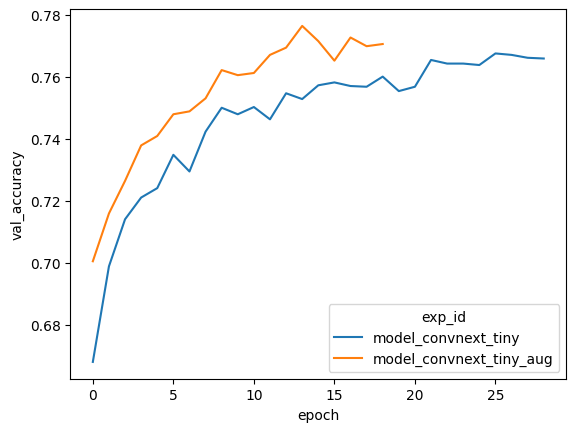

In [28]:
plot_experiments_comp(df_results,["model_convnext_tiny", "model_convnext_tiny_aug"], "val_accuracy")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

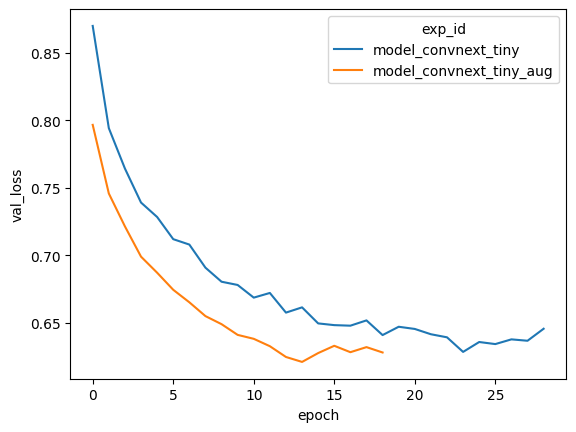

In [29]:
plot_experiments_comp(df_results,["model_convnext_tiny", "model_convnext_tiny_aug"], "val_loss")

In [18]:
#!rm -rf /kaggle/working/data